## Prioritizer Model

Trained model for classification and prioritization for ALFABURST events based on the labelled feature set from  featureBuilder.ipynb.

### Classifier model

Probabalistic classifier using random forests.

### Labels

#### RFI

* 1 : Unclipped RFI/Noise
* 2 : Wide-band, long-duration in time clipped RFI (2016+)
* 3 : Wide-band, short-duration in time clipped RFI (2016+)
* 4 : Wide-band, short duration clipped RFI (2015)
* 5 : Sharp bandpass transition
* 6 : Wide-band, bursty clipped RFI (2015)
* 7 : Error in spectra captue or replacement
* 8 : Systematic int/float overflow

#### Astronomical

* 0 : Interesting, follow up
* 9 : Known Pulsar

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Preamble

Read in the dataframe and prepare the features for use in scikit-learn.

In [280]:
pd.__version__

u'0.20.3'

In [281]:
df = pd.read_pickle('featureDateframe.pkl')

In [282]:
df.describe()

,Beam,Buffer,MJDstart,bestDM,bestSNR,BinFactor,Events,DMmax,DMmin,DMmean,...,pixelsMean133,pixelsMean140,pixelsMean141,pixelsMean142,pixelsMean143,pixelsMean150,pixelsMean151,pixelsMean152,pixelsMean153,DMin
count,73282.000000,73282.000000,73282.000000,73282.000000,73282.000000,73282.000000,7.328200e+04,73282.000000,73282.000000,73282.000000,...,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,1.553600e+04,15536.0
mean,3.556617,211.437952,57392.275750,994.132829,12.890546,14.171406,5.290837e+03,1843.879770,355.848537,1106.626399,...,-7.649538e+34,-1.288323e+34,1.429098e+34,-8.257392e+34,-5.166311e+34,-1.171005e+34,1.968355e+34,-5.147866e+34,-5.536758e+34,0.0
std,2.433997,272.753575,186.092812,2270.499049,79.265038,20.233713,3.448143e+04,3329.930528,1195.291547,2135.608269,...,1.325614e+36,2.036459e+36,2.037379e+36,1.691754e+36,1.241378e+36,1.969270e+36,2.078970e+36,1.700915e+36,1.240187e+36,0.0
min,0.000000,1.000000,57197.378446,0.000000,6.001704,1.000000,1.000000e+00,3.000000,0.000000,3.000000,...,-9.207459e+37,-6.056628e+37,-4.619998e+37,-3.490131e+37,-2.546661e+37,-5.667321e+37,-7.581628e+37,-3.265455e+37,-2.027739e+37,0.0
25%,1.000000,25.000000,57275.173537,7.000000,10.510364,2.000000,4.000000e+00,10.000000,5.000000,7.500000,...,0.000000e+00,-4.959372e+01,-1.515740e+01,-1.521857e+00,0.000000e+00,-4.950695e+01,-1.517410e+01,-1.548867e+00,0.000000e+00,0.0
50%,4.000000,111.000000,57328.330289,13.000000,11.301913,4.000000,3.400000e+01,27.000000,7.000000,16.500000,...,1.086369e+01,-1.265199e+01,-3.927948e+00,6.237355e+00,1.093944e+01,-1.249311e+01,-3.930597e+00,6.197421e+00,1.063596e+01,0.0
75%,6.000000,295.000000,57372.219326,273.000000,12.641252,16.000000,4.890000e+02,2024.000000,16.000000,947.812319,...,4.499946e+01,0.000000e+00,1.774699e+00,1.754257e+01,4.509341e+01,0.000000e+00,1.815087e+00,1.765943e+01,4.493125e+01,0.0
max,6.000000,2001.000000,57893.840891,10039.000000,20954.304688,64.000000,2.135578e+06,57287.182376,10035.000000,10035.500000,...,2.705174e+37,5.516305e+37,3.653238e+37,7.613141e+37,8.167050e+37,5.213531e+37,4.942519e+37,8.182356e+37,8.167050e+37,0.0


In [283]:
df.shape

(73282, 407)

#### Re-label Mis-labelled Type 8 Events

In [284]:
reLabel = [('Beam4_fb_D20150821T195709.fil', 202),
           ('Beam0_fb_D20150906T194609.fil', 275),
           ('Beam4_fb_D20150909T235709.fil', 467),
           ('Beam6_fb_D20150925T221909.fil', 3),
           ('Beam1_fb_D20151215T221703.fil', 377),
           ('Beam1_fb_D20151215T221703.fil', 595),
           ('Beam1_fb_D20151216T231103.fil', 50),
           ('Beam1_fb_D20151217T050412.fil', 196),
           ('Beam1_fb_D20151217T050412.fil', 197),
           ('Beam1_fb_D20151217T050412.fil', 202),
           ('Beam0_fb_D20160824T104004.fil', 1392),
           ('Beam0_fb_D20160825T003010.fil', 3),
           ('Beam0_fb_D20160824T104004.fil', 1392),
           ('Beam0_fb_D20160825T003010.fil', 3),
           ('Beam0_fb_D20170310T020409.fil', 6),
           ('Beam0_fb_D20170310T020409.fil', 8),
           ('Beam0_fb_D20170310T020409.fil', 9),
           ('Beam0_fb_D20170310T020409.fil', 11),
           ('Beam0_fb_D20170310T020409.fil', 14),
           ('Beam0_fb_D20170310T020409.fil', 15),
           ('Beam0_fb_D20170310T020409.fil', 16),
           ('Beam0_fb_D20170310T020409.fil', 17),
           ('Beam0_fb_D20170310T020409.fil', 19),
           ('Beam0_fb_D20170310T020409.fil', 21),
           ('Beam0_fb_D20170310T020409.fil', 25),
           ('Beam1_fb_D20170310T020409.fil', 4),
           ('Beam4_fb_D20170310T020409.fil', 7),
           ('Beam5_fb_D20170310T020409.fil', 1),
           ('Beam5_fb_D20170310T020409.fil', 2),
           ('Beam6_fb_D20170311T184903.fil', 2),
           ('Beam1_fb_D20170312T182504.fil', 2),
           ('Beam2_fb_D20170325T011509.fil', 1),
           ('Beam1_fb_D20170310T020409.fil', 3),
           ('Beam0_fb_D20170311T184903.fil', 2),
           ('Beam1_fb_D20170311T184903.fil', 1),
           ('Beam5_fb_D20170312T182504.fil', 1),
           ('Beam1_fb_D20170310T020409.fil', 2),
           ('Beam6_fb_D20170311T184903.fil', 3),
           ('Beam4_fb_D20170312T182504.fil', 10),
           ('Beam0_fb_D20170310T020409.fil', 2),
           ('Beam4_fb_D20170310T020409.fil', 4),
           ('Beam0_fb_D20170310T020409.fil', 1),
           ('Beam0_fb_D20170310T020409.fil', 3),
           ('Beam0_fb_D20170310T020409.fil', 4),
           ('Beam0_fb_D20170310T020409.fil', 5),
           ('Beam0_fb_D20170310T020409.fil', 7),
           ('Beam0_fb_D20170310T020409.fil', 10),
           ('Beam0_fb_D20170310T020409.fil', 12),
           ('Beam0_fb_D20170310T020409.fil', 13),
           ('Beam0_fb_D20170310T020409.fil', 18),
           ('Beam0_fb_D20170310T020409.fil', 20),
           ('Beam0_fb_D20170310T020409.fil', 22),
           ('Beam0_fb_D20170310T020409.fil', 23),
           ('Beam0_fb_D20170310T020409.fil', 24),
           ('Beam1_fb_D20170310T020409.fil', 1),
           ('Beam4_fb_D20170310T020409.fil', 3),
           ('Beam4_fb_D20170310T020409.fil', 5),
           ('Beam4_fb_D20170310T020409.fil', 6),
           ('Beam0_fb_D20170311T184903.fil', 1)]

In [285]:
# Relabel mis-labelled events to overflow (label 8)
for fil,buf in reLabel:
    #print fil, buf
    df.loc[(df['filterbank']==fil) & (df['Buffer']==buf), 'Label'] = 8

#### Compute MJD Features

We don't care about the absolute MJDs, but the relative offset within the dataset.

In [286]:
df['relMJDmax'] = df['MJDmax'] - df['MJDmin']
df['relMJDmean'] = df['MJDmean'] - df['MJDmin']
df['relMJDmedian'] = df['MJDmedian'] - df['MJDmin']

**Filter for only labelled data (i.e. Label > -1) and Drop Type 8 Events**

In [287]:
labelledDf = df[df['Label'] > -1] 
labelledDf = labelledDf[labelledDf['Label'] != 8] #delete column labelled by 8

**Relabel 0 to 9**

We are interested in both 9 and 0 labels and both appear similar.

In [288]:
labelledDf.loc[labelledDf['Label'] == 0, 'Label'] = 9 #finds indices where label is 0 or 9

In [289]:
for col in labelledDf:
    if labelledDf[col].dtype == object: #if labelledDf is an 'object' datatype - an array is not an object
        print col, labelledDf[col].min(), labelledDf[col].max() 
    else: 
        print col, labelledDf[col].min(), labelledDf[col].max(), labelledDf[col].std() #why does it do different stuff depending on whether it's an object or not

datfile Beam0_dm_D20150624T020452.dat Beam6_dm_D20170324T215304.dat
Beam 0 6 2.64289416941
TSID D20150624T020452 D20170325T092403
Buffer 1 1997 234.099730177
MJDstart 57197.3848466 57837.3807827 158.637469447
bestDM 51.0 10039.0 2925.42377249
bestSNR 10.0002756119 181.342330933 7.78511888853
BinFactor 1 64 23.3707904092
Events 1 1800508 63404.711047
DMmax 54.0 10039.0 3741.79111564
DMmin 0.0 10035.0 1854.50379848
DMmean 25.1612903226 10035.5 2705.60863642
DMmedian 9.0 10035.5 2819.01443151
DMstd 0.707106781187 4672.49363237 881.751739387
SNRmean 7.07141349051 19.9987541906 1.31552412109
SNRmedian 6.77030944824 15.0827293396 0.96828782134
SNRstd 0.000775502012695 14.4079302489 1.31336401293
MJDmax 57197.3848944 57837.3808056 158.637465108
MJDmin 57197.3848934 57837.3808055 158.637468173
MJDstd 0.0 4.11672955923e-05 8.34844478405e-06
MJDmean 57197.384894 57837.3808055 158.637466696
MJDmedian 57197.384894 57837.3808055 158.637466697
Label 1 9 2.14351963379
predictLabel -1 -1 0.0
filterban

windDedispTimeStatsMean12 -5129.89111328 3048.61914062 239.536466985
windDedispTimeStatsMean13 -4924.54199219 5055.21875 273.553585471
windDedispTimeStatsMean14 -8517.70898438 7211.52832031 348.684542159
windDedispTimeStatsMean15 -6393.93359375 6100.04101562 594.270549871
pixelsMax00 -53.5594825745 288.825500488 41.3531910913
pixelsMax01 -15.076748848 268.584747314 36.3891181363
pixelsMax02 -36.3486289978 1050.48168945 41.4322423898
pixelsMax03 -23.4307804108 425.801269531 46.6658634868
pixelsMax10 -54.0473976135 282.05456543 40.832405356
pixelsMax11 -19.9328174591 310.181671143 35.5210028028
pixelsMax12 -35.9993362427 1047.18005371 40.8390142302
pixelsMax13 -22.8797588348 450.725006104 46.3924568073
pixelsMax20 -53.5337677002 283.089782715 40.8251187157
pixelsMax21 -19.0611896515 293.414276123 35.7069742617
pixelsMax22 -36.2150497437 1053.2154541 41.0400596338
pixelsMax23 -23.3056411743 411.588195801 46.4270973972
pixelsMax30 -54.1617355347 281.867675781 40.935575157
pixelsMax31 -18.9

**Apply Direct Data Cleaning Filters**

In [290]:
# Check that data during March 2017 has been removed
for row in labelledDf.iterrows():
    idx, data = row
    if (data['globtsStatsMean'] < -3e3) or (data['globtsStatsMin'] < -3e3): 
        print idx
        
# Check that all events which overflow have been dropped
for row in labelledDf.iterrows():
    idx, data = row
    if data['ofCount'] > 0.: 
        print idx

In [291]:
print labelledDf.shape #13419 timeseries, 409 features

(13419, 410)


**Select out the labels**

In [292]:
labels = labelledDf['Label'].values

**Drop the meta-information columns**

In [293]:
labelledDf.columns #list column labels

Index([u'datfile', u'Beam', u'TSID', u'Buffer', u'MJDstart', u'bestDM',
       u'bestSNR', u'BinFactor', u'Events', u'DMmax',
       ...
       u'pixelsMean142', u'pixelsMean143', u'pixelsMean150', u'pixelsMean151',
       u'pixelsMean152', u'pixelsMean153', u'DMin', u'relMJDmax',
       u'relMJDmean', u'relMJDmedian'],
      dtype='object', length=410)

In [294]:
featureDf = labelledDf.drop(['Beam', 'Buffer', 'datfile', 'TSID', 'Label', 'predictLabel', 'filterbank'], axis=1) #delete the columns labelled by these strings

#### Drop Features that are not useful

In [295]:
featureDf = featureDf.drop(['MJDmax', 'MJDmean', 'MJDmedian', 'MJDmin'], axis=1) 

In [296]:
featureDf.columns

Index([u'MJDstart', u'bestDM', u'bestSNR', u'BinFactor', u'Events', u'DMmax',
       u'DMmin', u'DMmean', u'DMmedian', u'DMstd',
       ...
       u'pixelsMean142', u'pixelsMean143', u'pixelsMean150', u'pixelsMean151',
       u'pixelsMean152', u'pixelsMean153', u'DMin', u'relMJDmax',
       u'relMJDmean', u'relMJDmedian'],
      dtype='object', length=399)

### Pre-Processing

Prepare the features for model building: outliers (inf, NaN) need to be replaces, the features need to be scaled to zero mean, and unity variance.

In [297]:
import sklearn.preprocessing

**Convert feature dataframe to 2-D array of floats**

In [298]:
featuresArr = featureDf.values.astype('float32')
preProcLabels = labels.copy()

**Replace NaN and inf values**

In [299]:
featuresArr[featuresArr == -1. * np.inf] = np.nan
featuresArr[featuresArr == np.inf] = np.nan #set infinite values to nan (could u use .isinf more easily here?)
print featuresArr[featuresArr == np.nan]

#replace missing values with the mean along axis 0, np.nan values replaced with 'NaN' string
imp = sklearn.preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0).fit(featuresArr) #calibrate Imputer

preProcFeats = imp.transform(featuresArr) #use imputer on the featuresArr
print preProcFeats.shape, preProcLabels.shape

[]
(13419, 399) (13419,)


**Scale Features**

Robust scaling uses a median filter, this is better for non-Gaussian distributions

In [300]:
rScale = sklearn.preprocessing.RobustScaler().fit(preProcFeats)
print rScale.scale_
print rScale.center_

preProcFeats = rScale.transform(preProcFeats)

print preProcFeats.shape

[  2.86867188e+02   3.21850000e+03   7.15883636e+00   4.80000000e+01
   8.89450000e+03   7.41250000e+03   8.85500000e+02   4.27534602e+03
   4.14650000e+03   9.24252998e+02   1.44907618e+00   1.11415720e+00
   1.37039416e+00   8.56867777e-06   7.86132812e-02   3.72984851e-01
   1.00000000e+00   1.00000000e+00   8.80000000e+01   2.92968750e-03
   5.56640625e-02   4.22398668e+01   3.64588623e+01   6.99000000e+02
   3.30729279e+02   1.07910156e-01   4.88281250e-03   9.46647835e+01
   1.08398438e-01   6.94000000e+02   7.15298411e-01   1.62072275e+01
   4.22398668e+01   3.64588623e+01   6.99000000e+02   3.30729279e+02
   1.07910156e-01   4.88281250e-03   9.46647835e+01   1.08398438e-01
   6.94000000e+02   7.15298411e-01   1.62072275e+01   2.21605148e+01
   2.19934178e+01   2.12091744e+01   2.17518971e+01   2.21987066e+01
   2.21483584e+01   2.23650183e+01   2.22438739e+01   2.27477697e+01
   2.20860216e+01   2.03410908e+01   2.06588954e+01   2.18051176e+01
   2.24541343e+01   2.27288938e+01

### Classifier

In [301]:
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection

In [302]:
k_fold = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True)

In [303]:
randForest = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier()) #classifier for multiple labels

clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0,
            warm_start=False),
            n_jobs=1)

In [304]:
#Create a fitted model using all available features and all available training data:
fitmodel = clf.fit(preProcFeats, preProcLabels)

### Iterate over dropping successive features and fitting model

In [305]:
fullfeats = preProcFeats
fulllabels = preProcLabels

fimps = []
fullarr = []

#Create a list with each element one of the feature importance arrays for one of the estimators:
for idx in np.arange(8):
    importance = fitmodel.estimators_[idx].feature_importances_
    fimps.append(importance)
    
featureidxs = np.array([])
featurenumber = np.array([])
summed9probs = np.array([])
falsenegs = np.array([])

for i in np.arange(200):
    
    #Append next highest importance features to new features array & replace importance with 0:
    for idx in np.arange(8):
        fimp = fimps[idx]
        maxargs = np.argmax(fimp)
        maxargs = maxargs.astype(int)
        featureidxs = np.append(featureidxs, maxargs).astype(int)
        fimp[maxargs] = 0
        fimps[idx] = fimp
    
    #Make sure no feature indices are repeated & create new feature list:
    featureidxs = np.unique(featureidxs).astype(int)
    allidx = np.arange(fullfeats.shape[1]).astype(int)
    delfeats = np.delete(allidx, featureidxs).astype(int)
    features = np.delete(fullfeats, delfeats, axis=1).astype(int)
    
    #If maximum number of features has already been reached, break the for loop:
    if features[1].size == 300:
        print '300 features reached'
        break
    
    #Save the # of features for this iteration
    featurenumber = np.append(featurenumber, features.shape[1])
    featurenumber = featurenumber.astype(int)
    print '# of features: %d' %(features.shape[1])
    
    
    #Train the model with new list of features:
    xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(features,\
                                                            fulllabels, test_size=0.25, random_state=420)
    trainedmodel = clf.fit(xtrain, ytrain)
    
    #Predict probabilities for each known pulsar time series:
    args9 = np.argwhere(ytest == 9).astype(int)
    args9 = args9.flatten()
    prediction = trainedmodel.predict_proba(xtest)
    is9 = prediction[args9]
    
        
    #Sum all predicted probabilities of being in class 9 for time series labelled with 9:
    probs9is9 = is9[:,7]
    falseneg = np.argwhere(probs9is9 < 0.2).size
    print '# of false negatives: %d' %falseneg
    falsenegs = np.append(falsenegs, falseneg)
    prob9sum = np.sum(probs9is9)
    prob9sum /= args9.size
    summed9probs = np.append(summed9probs, prob9sum)

# of features: 5
# of false negatives: 172
# of features: 11
# of false negatives: 133
# of features: 17
# of false negatives: 86
# of features: 22
# of false negatives: 42
# of features: 28
# of false negatives: 41
# of features: 33
# of false negatives: 39
# of features: 35
# of false negatives: 40
# of features: 38
# of false negatives: 32
# of features: 42
# of false negatives: 27
# of features: 49
# of false negatives: 22
# of features: 54
# of false negatives: 23
# of features: 56
# of false negatives: 21
# of features: 60
# of false negatives: 19
# of features: 64
# of false negatives: 15
# of features: 69
# of false negatives: 18
# of features: 72
# of false negatives: 16
# of features: 76
# of false negatives: 14
# of features: 79
# of false negatives: 16
# of features: 84
# of false negatives: 18
# of features: 90
# of false negatives: 17
# of features: 95
# of false negatives: 15
# of features: 99
# of false negatives: 17
# of features: 102
# of false negatives: 18
# of feat

KeyboardInterrupt: 

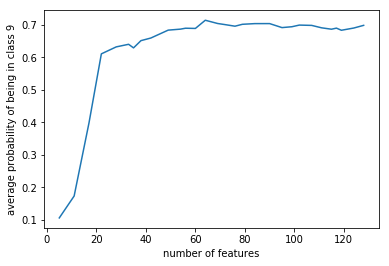

In [313]:
plt.plot(featurenumber[:30], summed9probs[:30])
plt.ylabel('average probability of being in class 9')
plt.xlabel('number of features')
plt.show()

(162,)


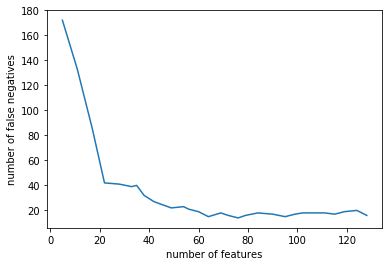

In [314]:
plt.plot(featurenumber[:30], falsenegs[:30])
plt.ylabel('number of false negatives')
plt.xlabel('number of features')
plt.show()